In [13]:
from time import time
from numpy import exp, sqrt, log
from random import gauss, seed

#Params
S0 = 100.
K = 105.
T = 1.
r = 0.05
sigma = 0.2
M = 50
dt = T / M
I = 250000

In [11]:
#Pure Python
seed(20000)
t0 = time()
S = []
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0, 1.)
            St = path[t-1] * exp((r - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * z)
            path.append(St)

    S.append(path)

C0 = exp(-r * T) * sum([max(path[-1] - K, 0) for path in S]) / I    
tpy = time() - t0

In [12]:
print(C0)
print(tpy)

7.99904488818
43.8648841381


In [21]:
#Numpy
import numpy as np
np.random.seed(20000)
t0 = time()

S = np.zeros((M + i, I))
S[0] = S0
for t in range(1, M +1):
    z = np.random.standard_normal(I)
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    
C0 = np.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0))/I
tnp1 = time() - t0

In [22]:
tnp1

0.4842970371246338

In [25]:
#Fully vectorized Numpy
t0 = time()
S = S0*np.exp(np.cumsum((r - 0.5*sigma**2) * dt 
                        + sigma * np.sqrt(dt)
                       * np.random.standard_normal((M+1, I)), axis=0))
S[0] = S0
C0 = np.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0))/I
tnp2 = time() - t0

In [26]:
tnp2

0.588407039642334

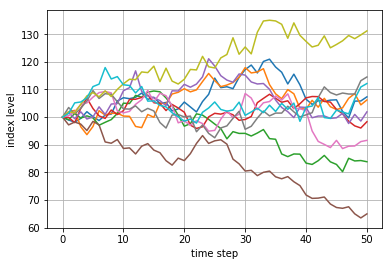

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.plot(S[:, :10]);
plt.grid(True);
plt.xlabel('time step');
plt.ylabel('index level');

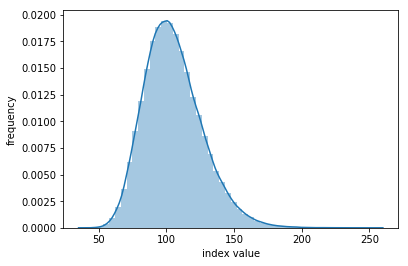

In [53]:
ax = sns.distplot(S[-1], bins= 50, axlabel='index value');
ax.set_ylabel('frequency');



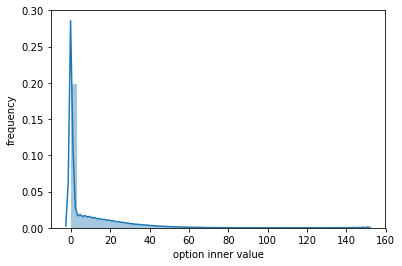

In [56]:
ax = sns.distplot(np.maximum(S[-1] - K, 0), bins=50)
ax.set_xlabel('option inner value')
ax.set_ylabel('frequency')
# ax.set_ylim(0, 5000)

In [59]:
np.sum(S[-1] < K)

134315

In [76]:
import pandas_datareader as pdr
import pandas as pd

In [69]:
sp500 = pdr.get_data_yahoo('^GSPC')
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1965 entries, 2010-01-04 to 2017-10-20
Data columns (total 6 columns):
Open         1965 non-null float64
High         1965 non-null float64
Low          1965 non-null float64
Close        1965 non-null float64
Adj Close    1965 non-null float64
Volume       1965 non-null int64
dtypes: float64(5), int64(1)
memory usage: 107.5 KB


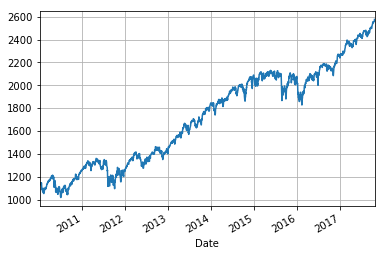

In [75]:
sp500['Close'].plot(grid=True);

In [78]:
sp500['42d'] = np.round(sp500['Close'].rolling(window=42).mean(), 2)
sp500['252d'] = np.round(sp500['Close'].rolling(window=252).mean(), 2)

In [79]:
sp500[['Close', '42d', '252d']].tail()

,Close,42d,252d
Date,,,
2017-10-16,2557.639893,2494.15,2360.65
2017-10-17,2559.360107,2497.23,2362.37
2017-10-18,2561.260010,2500.46,2364.04
2017-10-19,2562.100098,2503.64,2365.70
2017-10-20,2575.209961,2506.57,2367.42


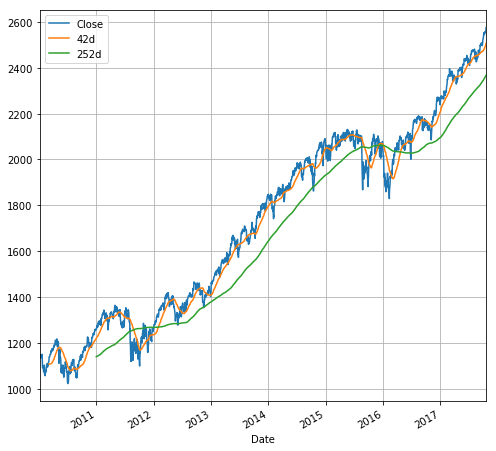

In [81]:
sp500[['Close', '42d', '252d']].plot(grid=True, figsize=(8,8));

In [86]:
#vectorized mathematical operations
sp500['42-252'] = sp500['42d'] - sp500['252d']
sp500['42-252'].tail()

Date
2017-10-16    133.50
2017-10-17    134.86
2017-10-18    136.42
2017-10-19    137.94
2017-10-20    139.15
Name: 42-252, dtype: float64

In [89]:
#Regimes represent protocols to initiate action
SD = 50
#set values in a new column called 'regime'
#if diff greater than SD, set to 1, otherwise 0
sp500['Regime'] = np.where(sp500['42-252'] > SD,1, 0)
#if diff lt SD, set to neg1 else, keep as the value in 'regime
sp500['Regime'] = np.where(sp500['42-252'] < SD,-1, sp500['Regime'])

sp500['Regime'].value_counts()

 1    1288
-1     426
 0     251
Name: Regime, dtype: int64

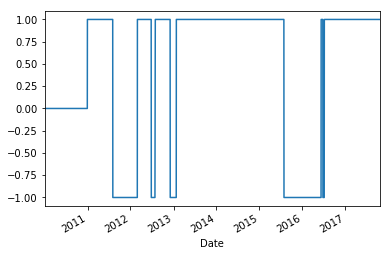

In [90]:
#the regime shifts from neutral to positive, to negative and back and forth
sp500['Regime'].plot(lw=1.5)

In [91]:
#compute marketreturn as the log one close divided by the next day close
sp500['Market'] = np.log(sp500['Close']/sp500['Close'].shift(1))

In [93]:
sp500['Strategy'] = sp500['Regime'].shift(1) * sp500['Market']

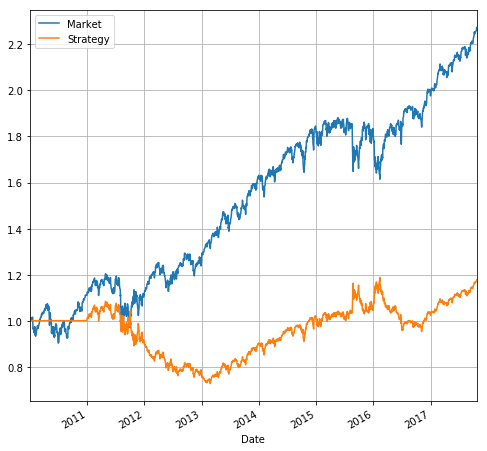

In [99]:
#This is interesting. We can see that this is an underperforming strategy
#in the current market environment. In a bull market this is not a good strategy. 
#This is an appropriate strategy for a bear market.
sp500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(8,8))